In [3]:
# Keras implementation of text classifier with custom Embedding and 
# This code implements character level and word level encodings
# 
# Author: Karthik D

%matplotlib inline
import pandas as pd
import numpy as np
import tensorflow as tf
from numpy import array
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from numpy import array_equal
from keras.models import Sequential
from keras_self_attention import SeqSelfAttention
from sklearn.model_selection import train_test_split
from keras import layers
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Flatten, RepeatVector
from keras.layers import Bidirectional, concatenate, SpatialDropout1D
from keras.layers.normalization import BatchNormalization
from keras.models import load_model
from collections import Counter

import random
import statistics
import text_utils as tu
import modeling_utils as mu

plt.style.use('ggplot')

In [4]:
# Read datas
data = pd.read_csv('ml_test_dataset_13K.csv')
print(data.shape)

(13000, 7)


In [5]:
# Some variables
seed = 1234
THRESHOLD = 5 #threshold for uncommon character count cut off

n_classes = data.category_name.nunique()
random.seed(seed)
np.random.seed(seed)
tf.compat.v1.random.set_random_seed(seed)

# DV Distribution

In [6]:
# One hot encode category
data['y'] = mu.onehot_encode(data.category_name)
mu.get_dv_dist(data,'id', 'category_name')

category_name,0,1,2,3,4,5,6,7,8,9,10,11,12
counts,1050.00,1028.00,965.00,1035.00,971.00,970.00,1017.00,1048.00,992.00,989.00,947.00,1002.00,986.00
perc (%),8.08,7.91,7.42,7.96,7.47,7.46,7.82,8.06,7.63,7.61,7.28,7.71,7.58


# Data Cleaning

In [7]:
# Basic cleaning - removing some characters from raw text
data['purpose_clean'] = data.purpose.str.replace(r'[0-9!@$%^&*()+_,\\\-:/.]', "").fillna('')
data['counterpart_name_clean'] = data.counterpart_name.str.replace(r'[0-9!@$%^&*()+_,\\\-:/.]', "").fillna('')

# Combine purpose and counterpart as one feature
data['x_char'] = data.purpose.str.replace(r'[0-9\\\-]', "").fillna('').str.lower() + " " + data.counterpart_name.str.replace(r'[0-9\\\-]', "").fillna('').str.lower()
data['x_word'] = data.purpose_clean.str.lower() + " " + data.counterpart_name_clean.str.lower()

dev = data.dropna(how='any')

# Calculate max length of text
max_seq_length = dev.x_word.str.strip().str.split().apply(len).max()
print("Max [word] sequence length:", max_seq_length)
   
print("size of data:", len(dev.x_word))

Max [word] sequence length: 67
size of data: 13000


# Find the most frequent tokens

In [8]:
Counter(" ".join(dev["x_char"]).split()).most_common(5)
Counter(" ".join(dev["x_word"]).split()).most_common(5)

[('num', 15955),
 ('letnum', 4307),
 ('datetime', 2388),
 ('gmbh', 1887),
 ('sdate', 1834)]

In [9]:
# Count the number of occurances of a key in col by category
def count_word_by_DV(df, gp_by_col, x_col, s):
    c_nums_word = dev.groupby([gp_by_col])[x_col].apply(lambda x: x[x.str.contains(s)].count())
    c_nums_word = c_nums_word.rename(c_nums_word.name+"_"+s)
    return c_nums_word
    
pd.concat([ \
           count_word_by_DV(dev, 'category_name', 'x_word', 'letnum'),\
           count_word_by_DV(dev, 'category_name', 'x_word', 'num'),\
           count_word_by_DV(dev, 'category_name', 'x_word', 'datetime'),\
           count_word_by_DV(dev, 'category_name', 'x_word', 'gmbh')\
          ], axis=1)


,x_word_letnum,x_word_num,x_word_datetime,x_word_gmbh
category_name,,,,
0,195,540,10,120
1,512,878,573,12
2,124,632,8,261
3,294,730,111,220
4,264,610,300,82
5,231,542,16,69
6,299,599,417,293
7,299,582,290,346
8,181,469,179,57


Since the tokens "num" and "letnum" are most frequent and have low variability w.r.t the DV, we shall remove these tokens 

In [10]:
# Remove noisy text
dev.x_char = dev.x_char.str.replace("LETNUM", "").str.replace("NUM", "")
dev.x_char = dev.x_char.str.replace("letnum", "").str.replace("num", "")
dev.x_word = dev.x_char.str.replace("letnum", "").str.replace("num", "")

# Make Word level Tensors

In [11]:
# Setting max padded sequence length = 70
max_len = 70
vocab = tu.make_vocab(dev.x_word)
w2i = tu.make_w2i(vocab)

x_word = tu.make_tensor_np(dev.x_word, w2i, max_len)
y = np.stack(dev.y.to_numpy())

print("X word sequence tensor shape:", x_word.shape)
print("y shape:", y.shape)

Vocab size: 16228
X word sequence tensor shape: (13000, 70)
y shape: (13000, 13)


# Make Char level Tensors

In [12]:
unique_symbols, uncommon_symbols = tu.get_characters(dev.x_char, 5)

# Replace Uncommon chars with a placeholder:
DUMMY = uncommon_symbols[0]
tr_table = str.maketrans("".join(uncommon_symbols), DUMMY * len(uncommon_symbols))
dev['x_char'] = dev.x_char.apply(lambda x: x.translate(tr_table))

Unique symbols: 34


## Tokenize the character sequences

In [13]:
# We will need the number of unique symbols further down when we will decide on the dimensionality of inputs.
num_unique_symbols = len(unique_symbols) - len(uncommon_symbols) + 1 

tokenizer = Tokenizer(
    char_level=True,
    filters=None,
    lower=False,
    num_words=num_unique_symbols
)

tokenizer.fit_on_texts(dev.x_char)
char_sequences = tokenizer.texts_to_sequences(dev.x_char)

In [14]:
print(statistics.median([len(x) for x in char_sequences]))
max_char_seq_len = 70

51.0


## Get padded character sequences

In [15]:
# Pad the input: I use maxlen=60, just a bit over the median length.
padded_char_sequences = pad_sequences(char_sequences, maxlen=max_char_seq_len)
padded_char_sequences.shape

(13000, 70)

# Train test Split

In [16]:
# Get word level splits
x_train_wor, x_test_wor, y_train, y_test1 = train_test_split(x_word, y, test_size=0.3, random_state=201)
x_test_wor, x_val_wor , y_test, y_val = train_test_split(x_test_wor, y_test1, test_size=0.5, random_state=201)

# Get character level splits
x_train_char, x_test_char, _, _ = train_test_split(padded_char_sequences, y, test_size=0.3, random_state=201)
x_test_char, x_val_char, _, _ = train_test_split(x_test_char, y_test1, test_size=0.5, random_state=201)

print("Train words X Size:", x_train_wor.shape)
print("Val words X Size:", x_val_wor.shape)
print("Test words X size:", x_test_wor.shape)
print("----------------------------------------")
print("Train chars X Size:", x_train_char.shape)
print("Val chars X Size:", x_val_char.shape)
print("Test chars X size:", x_test_char.shape)
print("----------------------------------------")
print("Train Y Size:", y_train.shape)
print("Test Y size:", y_test.shape)
print("Val Y Size:", y_val.shape)

# TODO show DV dist for every sample

Train words X Size: (9100, 70)
Val words X Size: (1950, 70)
Test words X size: (1950, 70)
----------------------------------------
Train chars X Size: (9100, 70)
Val chars X Size: (1950, 70)
Test chars X size: (1950, 70)
----------------------------------------
Train Y Size: (9100, 13)
Test Y size: (1950, 13)
Val Y Size: (1950, 13)


# DV Distribution by dataset

In [17]:
# TODO: make reports, write to csv
print("Train DV distribution:-------------------------------------------------------------------- ")
print(mu.get_dv_dist(y_train))
print("Val DV distribution:------------------------------------------------------------------------ ")
print( mu.get_dv_dist(y_val))
print("Test DV distribution:------------------------------------------------------------------------ ")
print(mu.get_dv_dist(y_test))

Train DV distribution:-------------------------------------------------------------------- 
            0      1      2      3      4      5      6      7      8      9   \
counts   732.0  715.0  671.0  745.0  661.0  680.0  710.0  751.0  701.0  692.0   
perc(%)    8.0    7.9    7.4    8.2    7.3    7.5    7.8    8.3    7.7    7.6   

            10     11     12  
counts   647.0  697.0  698.0  
perc(%)    7.1    7.7    7.7  
Val DV distribution:------------------------------------------------------------------------ 
            0      1      2      3      4      5      6      7      8      9   \
counts   162.0  146.0  143.0  145.0  173.0  136.0  164.0  140.0  137.0  155.0   
perc(%)    8.3    7.5    7.3    7.4    8.9    7.0    8.4    7.2    7.0    7.9   

            10     11     12  
counts   155.0  153.0  141.0  
perc(%)    7.9    7.8    7.2  
Test DV distribution:------------------------------------------------------------------------ 
            0      1      2      3      4    

# Model

In [18]:
# This is the model architecture:
# Embed words in custom word embedding layer
# Embed characters in custom char level embedding leyer
# Experiment with self attention (didn't give a good val loss)

vocab_size = len(vocab)
max_len_char = 10

# input and embedding for words
word_in = Input(shape=(max_len,))
emb_word = Embedding(input_dim=vocab_size, output_dim=30,
                     input_length=max_len, mask_zero=False, trainable=True)(word_in)
bn_wemb = BatchNormalization()(emb_word)
bn_wemb = Dropout(rate=0.4)(bn_wemb)

#word_attn = SeqSelfAttention(attention_activation='sigmoid')(bn_wemb)
#---------------------------------------------------------------------------------------------------------
# input and embeddings for characters
char_in = Input(shape=(max_char_seq_len,))
emb_char = Embedding(input_dim=num_unique_symbols, output_dim=10,
                           input_length=max_char_seq_len, mask_zero=False, trainable=True)(char_in)
bn_cemb = BatchNormalization()(emb_char)
bn_cemb = Dropout(rate=0.4)(bn_cemb)

#---------------------------------------------------------------------------------------------------------
# main LSTM
x = concatenate([bn_wemb, bn_cemb])
x = SpatialDropout1D(0.3)(x)
main_lstm = Bidirectional(LSTM(units=32, return_sequences=True,
                               recurrent_dropout=0.2))(x)
#---------------------------------------------------------------------------------------------------------
x = Flatten()(main_lstm)
x = Dropout(rate=0.4)(x)
x = Dense(50, activation="tanh")(x)
x = Dropout(rate=0.4)(x)
out = Dense(n_classes, activation="softmax")(x)

model = Model([word_in, char_in], out)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 70)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 70, 30)       486840      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 70, 10)       320         input_2[0][0]                    
____________________

# Train

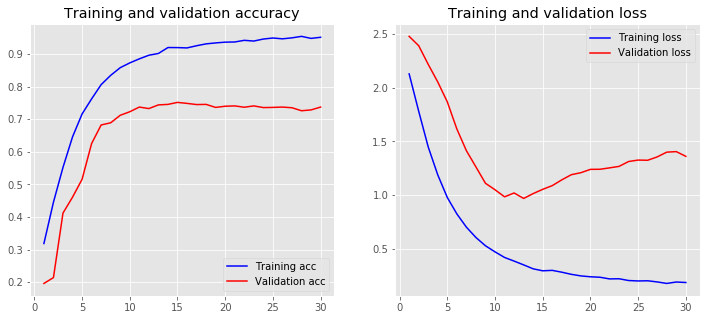

In [20]:
# train LSTM
history = model.fit([x_train_wor, x_train_char],
                    y_train,
                    batch_size=256, 
                    epochs=30, 
                    validation_data=([x_val_wor, x_val_char], y_val),
                    #validation_split=0.1,
                    verbose=0)
mu.plot_history(history)

Model overfits after about 12 epochs. This may be due to small dataset size 

In [21]:
loss, accuracy = model.evaluate([x_train_wor, x_train_char], y_train, verbose=2)
print("Training Accuracy: ", round(accuracy*100, 2),"%" )
print("Training Loss: ", loss )
loss, accuracy = model.evaluate([x_val_wor, x_val_char], y_val, verbose=2)
print("Validation Accuracy: ", round(accuracy*100, 2),"%" )
print("Validation Loss: ", loss )
loss, accuracy = model.evaluate([x_test_wor, x_test_char], y_test, verbose=2)
print("Test Accuracy: ", round(accuracy*100, 2),"%" )
print("Test Loss: ", loss )

Training Accuracy:  97.18 %
Training Loss:  0.09981335679376191
Validation Accuracy:  73.69 %
Validation Loss:  1.3610733182613666
Test Accuracy:  73.28 %
Test Loss:  1.4101107701277122


In [23]:
train_met, _,_,_,_ = mu.get_model_metrics(model, [x_train_wor, x_train_char], y_train)
val_met, _,_,_,_ = mu.get_model_metrics(model, [x_val_wor, x_val_char], y_val)
test_met, _,_,_,_ = mu.get_model_metrics(model, [x_test_wor, x_test_char], y_test)

train_accu = train_met.loc['micro avg'][0]
train_met = train_met.drop('micro avg', axis=0)
test_accu = test_met.loc['micro avg'][0]
test_met = test_met.drop('micro avg', axis=0)
val_accu = val_met.loc['micro avg'][0]
val_met = val_met.drop('micro avg', axis=0)

1950/1950 [==============================] - 3s 1ms/step


In [24]:
print("Train Precision (%): ", list(round(train_met.precision*100, 1)))
print("Train Recall (%): ", list(round(train_met.recall*100, 1)))
print("Train F1 (%): ", list(round(train_met['f1-score']*100, 1)))
print('Train Accuracy (%): ', round(train_accu*100, 2))
print("----------------------------------------------------------------------------------------------------")
print("Test Precision (%): ", list(round(test_met.precision*100, 1)))
print("Test Recall (%): ", list(round(test_met.recall*100, 1)))
print("Test F1 (%): ", list(round(test_met['f1-score']*100, 1)))
print('Test Accuracy (%): ', round(test_accu*100, 2))
print("----------------------------------------------------------------------------------------------------")
print("Val Precision (%): ", list(round(val_met.precision*100, 1)))
print("Val Recall (%): ", list(round(val_met.recall*100, 1)))
print("Val F1 (%): ", list(round(val_met['f1-score']*100, 1)))
print('Val Accuracy (%): ', round(val_accu*100, 2))


Train Precision (%):  [98.6, 95.6, 94.7, 99.7, 99.9, 97.4, 99.9, 96.9, 99.4, 90.0, 94.7, 99.3, 98.4]
Train Recall (%):  [97.8, 97.6, 96.8, 99.7, 95.6, 99.3, 93.3, 95.2, 98.5, 97.2, 98.1, 96.3, 98.1]
Train F1 (%):  [98.2, 96.6, 95.7, 99.7, 97.7, 98.3, 96.5, 96.0, 99.0, 93.4, 96.4, 97.8, 98.3]
Train Accuracy (%):  97.18
----------------------------------------------------------------------------------------------------
Test Precision (%):  [81.9, 74.5, 65.4, 91.1, 64.0, 71.7, 77.7, 67.8, 77.3, 54.1, 72.9, 77.9, 80.6]
Test Recall (%):  [78.2, 82.0, 60.0, 94.1, 70.1, 75.5, 60.0, 58.4, 75.3, 69.2, 79.0, 70.8, 76.1]
Test F1 (%):  [80.0, 78.1, 62.6, 92.6, 66.9, 73.5, 67.7, 62.7, 76.3, 60.7, 75.8, 74.1, 78.3]
Test Accuracy (%):  73.28
----------------------------------------------------------------------------------------------------
Val Precision (%):  [83.6, 75.0, 67.7, 92.2, 65.8, 74.4, 65.0, 66.9, 72.7, 61.5, 69.1, 85.6, 82.4]
Val Recall (%):  [75.3, 84.2, 67.7, 92.8, 68.1, 81.1, 53.8, 60.

# Assignment 3

In [25]:
# Prepare data to score 

x_word_tensor = tu.make_tensor_np(dev.x_word, w2i, max_len)
x_char_tensor = padded_char_sequences
y_tensor = np.stack(dev.y.to_numpy())

In [26]:
# Score model
met, y_pred, scores1, y_2nd_pred, scores2 = mu.get_model_metrics(model, [x_word_tensor, x_char_tensor], y=y_tensor)

13000/13000 [==============================] - 17s 1ms/step


In [27]:
# Return mispredicted datapoints
def return_mismatch_ind(act, pred):
    ind = np.arange(len(act))[act != pred]
    return ind

mis_ind = return_mismatch_ind(dev.category_name, y_pred)

In [28]:
mispredicted_df = dev.iloc[mis_ind].copy()
mispredicted_df['pred_cat_1'] = y_pred[mis_ind]
mispredicted_df['prob1'] = scores1[mis_ind]
mispredicted_df['pred_cat_2'] = y_2nd_pred[mis_ind]
mispredicted_df['prob2'] = scores2[mis_ind]
mispredicted_df = mispredicted_df[['id', 'purpose', 'category_name', 'pred_cat_1', 'prob1', 'pred_cat_2', 'prob2']]
mispredicted_df.columns = ['transaction_id', 'purpose', 'real_category', 'predicted_category_1', 'probability_1', 'predicted_category_2', 'probability_2']

In [29]:
print('Total # of mispredictions:', mispredicted_df.shape[0])
mispredicted_df.to_csv("Mispredicted_transactions.csv")

Total # of mispredictions: 1291
